In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
from google.colab import drive
from keras.models import Sequential
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np



In [ ]:

# zip_path = '/content/drive/MyDrive/AI/Pekman/my_data/smile/smile_data.zip'


# extract_path = '/content/drive/MyDrive/AI/Pekman/my_data/smile'

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall(extract_path)

In [ ]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Found 582 validated image filenames belonging to 2 classes.
Found 146 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Label Mappings for classes present in the training and validation datasets

0 : fake_smile
1 : smile


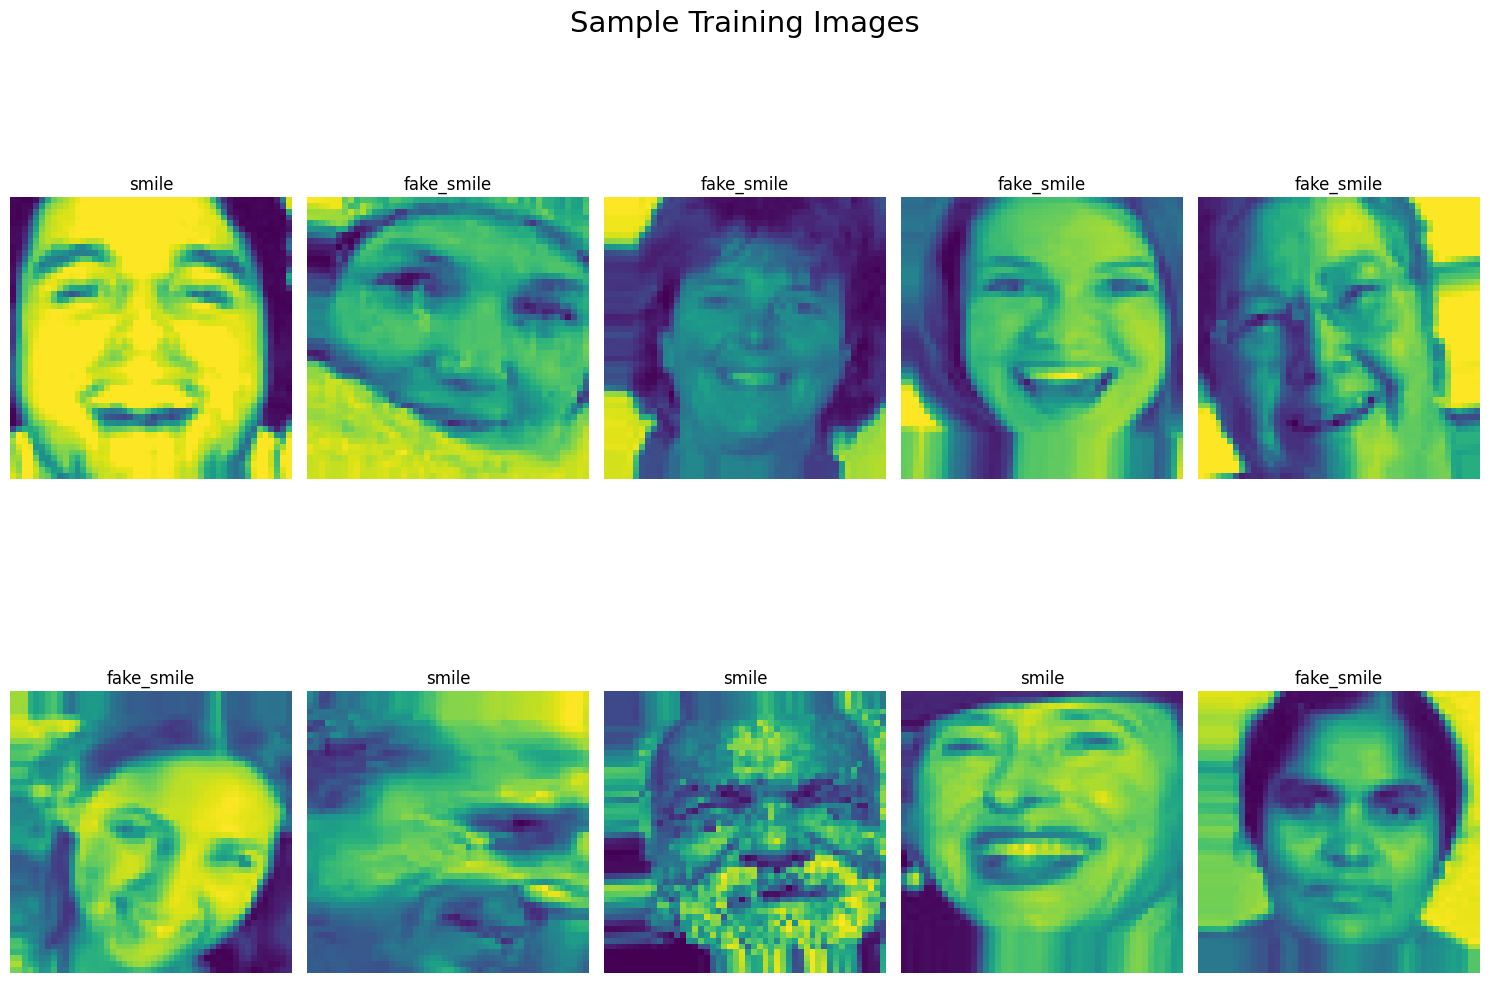

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 128)       3328      
                                                                 
 activation (Activation)     (None, 44, 44, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 128)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 22, 22, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 64)        73792     
                                                                 
 activation_1 (Activation)   (None, 20, 20, 64)        0

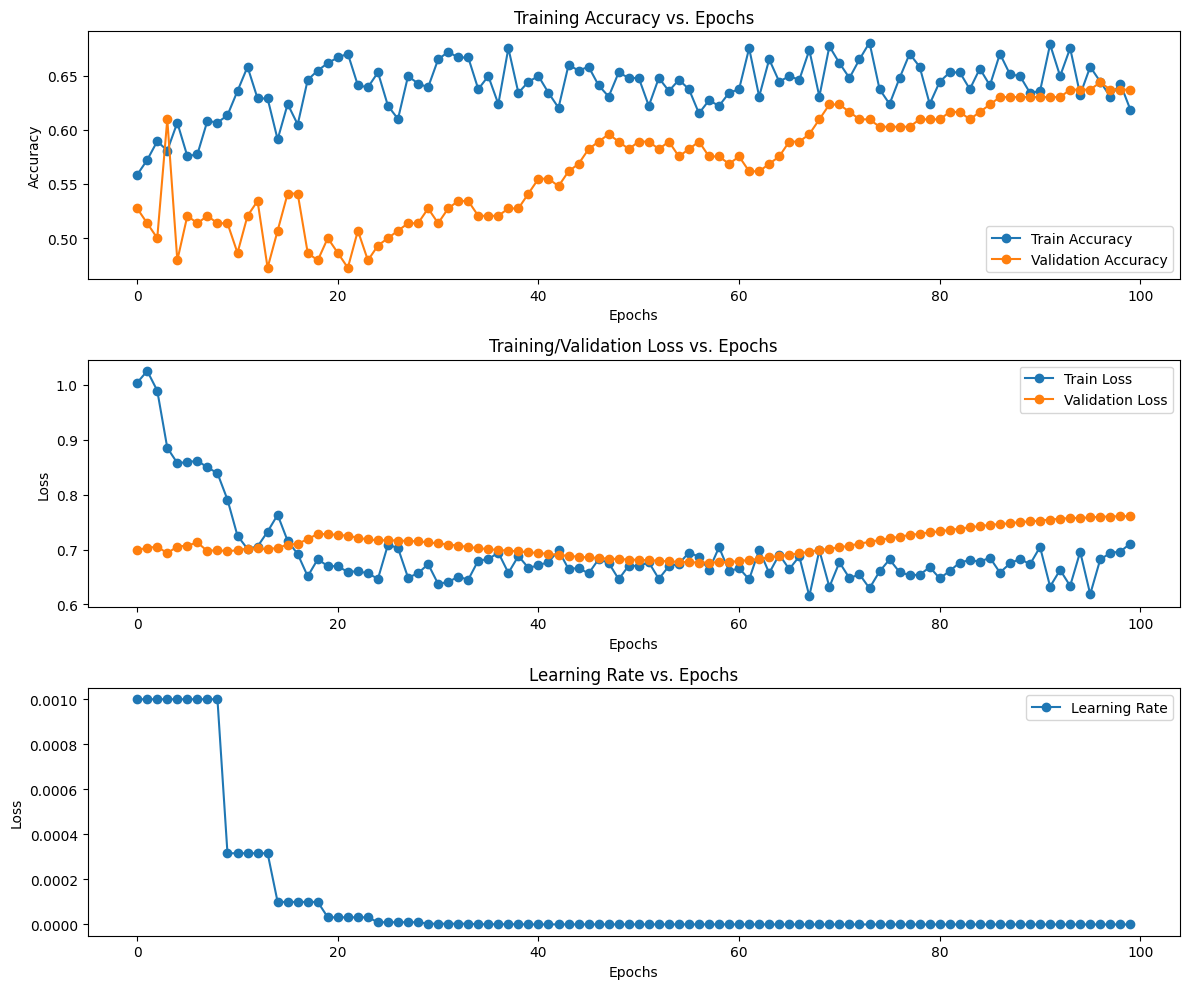

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

data_loc = '/content/drive/MyDrive/AI/Pekman/my_data/sad/sad_data'


image_files = []
labels = []

for emotion_folder in os.listdir(data_loc):
    emotion_path = os.path.join(data_loc, emotion_folder)
    if os.path.isdir(emotion_path):
        for image_file in os.listdir(emotion_path):
            image_path = os.path.join(emotion_path, image_file)
            image_files.append(image_path)
            labels.append(emotion_folder)


train_files, test_files, train_labels, test_labels = train_test_split(
    image_files, labels, test_size=0.2, random_state=42, stratify=labels
)

img_size = 48
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2]
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_files, 'class': train_labels}),
    x_col="filename",
    y_col="class",
    target_size=(img_size, img_size),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical"
)

test_data = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': test_files, 'class': test_labels}),
    x_col="filename",
    y_col="class",
    target_size=(img_size, img_size),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical"
)

labels = {value: key for key, value in train_data.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_data[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_data[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()


def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(48, 48, 1)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),

        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=2, activation='softmax')
    ])

    return model

cnn_model = create_model()
print(cnn_model.summary())

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

epochs = 15
batch_size = 32

optimizer = Adam(learning_rate=0.001)

cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = cnn_model.fit(train_data, epochs=100, validation_data=test_data,
                       verbose=2,
                       callbacks=[reduce_lr])


train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

cnn_model.save('/content/drive/MyDrive/AI/Pekman/my_data/smile/smile_fake_real_model.h5')


